In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from keras.models import Sequential
from keras.layers import Dense

#Reading in our training data
df = pd.read_csv("./kaggle/chessData.csv")
#Reading in our validation data
Edf = pd.read_csv("./kaggle/random_evals.csv")

In [20]:
df.head(10)

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
5,rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQ...,+50
6,rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQ...,+10
7,rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQ...,+75
8,rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1B...,+52
9,rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1...,+52


In [30]:
from sklearn.model_selection import train_test_split

def FENtoVEC (FEN):
    pieces = {"r":5,"n":3,"b":3.5,"q":9.5,"k":20,"p":1,"R":-5,"N":-3,"B":-3.5,"Q":-9.5,"K":-20,"P":-1}
    FEN = list(str(FEN.split()[0]))
    VEC = []
    for i in range(len(FEN)):
        if FEN[i] == "/":
            continue
        if FEN[i] in pieces:
            VEC.append(pieces[FEN[i]])
        else:
            em = [VEC.append(0) for i in range(int(FEN[i]))]

    return VEC

#Preparing training data
df = df.head(400000)
board = df["FEN"].tolist()
evl = np.asarray([float(i.strip("#+")) for i in df["Evaluation"].tolist()])
evl = np.clip(evl, -1000, 1000) / 1000
NNtrainX = np.asarray([FENtoVEC(state) for state in board])
NNtrainy = evl

NNtrainX = NNtrainX.reshape(-1, 8, 8, 1)  # Reshape to (num_samples, 8, 8, 1)

X_temp, X_test, y_temp, y_test = train_test_split(NNtrainX, NNtrainy, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


Epoch 1/1000
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1744 - mean_squared_error: 0.0835 - val_loss: 0.1729 - val_mean_squared_error: 0.0823
Epoch 2/1000
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1713 - mean_squared_error: 0.0804 - val_loss: 0.1721 - val_mean_squared_error: 0.0815
Epoch 3/1000
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1691 - mean_squared_error: 0.0783 - val_loss: 0.1691 - val_mean_squared_error: 0.0771
Epoch 4/1000
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1671 - mean_squared_error: 0.0764 - val_loss: 0.1690 - val_mean_squared_error: 0.0779
Epoch 5/1000
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1651 - mean_squared_error: 0.0749 - val_loss: 0.1670 - val_mean_squared_error: 0.0761
Epoch 6/1000
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1630 - mean_squared_error: 0.0731 - val_loss: 0.1677 - val_mean_squared_error: 0.076

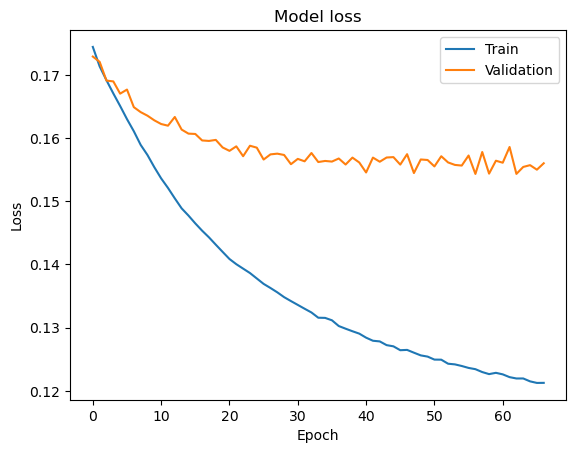

In [41]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'],steps_per_execution = 32)


history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()




In [39]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test MAE:', test_mae)

2500/2500 [==============================] - 1s 576us/step - loss: 0.1613 - mean_squared_error: 0.0714
Test MAE: 0.07135850191116333


In [33]:
predictions = model.predict(X_test)
predictions

2500/2500 [==============================] - 1s 203us/step


array([[ 1.17135026e-01],
       [ 2.59141140e-02],
       [ 6.39426580e-05],
       ...,
       [ 2.59141140e-02],
       [-3.84882614e-02],
       [ 2.59141140e-02]], dtype=float32)

In [34]:
model.save('model')

import joblib

joblib.dump(model, './model.joblib')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


['./model.joblib']

In [ ]:
FENtoVEC("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")

[5,
 3,
 3.5,
 9.5,
 20,
 3.5,
 3,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -5,
 -3,
 -3.5,
 -9.5,
 -20,
 -3.5,
 -3,
 -5]

In [ ]:
# Convert FEN to vector
fen_vec = [FENtoVEC("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR")]

# Ensure the input is in the correct format
fen_vec = np.asarray(fen_vec)

# Make a prediction
prediction = model.predict(fen_vec)
prediction2 = forest_model.predict(fen_vec)

prediction[0][0]


ValueError: in user code:

    File "/Users/andrew/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/engine/training.py", line 2175, in predict_function  *
        outputs = step_function(self, iterator)
    File "/Users/andrew/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/andrew/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/andrew/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/andrew/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/andrew/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 64), found shape=(None, 63)


In [ ]:
import joblib

joblib.dump(forest_model, './forest_model.joblib')

['./forest_model.joblib']